In [7]:
import os
import glob
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_directory = "./data/CEBS/m001"
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_db = 10

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

#num_epochs = 1024
#batch_size = 64
#learning_rate = 0.001
#weight_decay = 0.01

In [9]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / np.sum((signal_clean - signal_noisy) ** 2))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / np.sqrt(mse(signal_clean, signal_noisy)))

def xcorr(signal_clean, signal_noisy):
    return np.correlate(signal_clean, signal_noisy)

In [10]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    # frequency = metadata['fs']
    column_names = metadata['sig_name']
    # length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    # frequency_string = str(int(1/frequency*1000000)) + 'U'
    # index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    # data.set_index(index, inplace=True)
    # data.resample(sampling_rate).mean().SCG
    
    return data

In [11]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*m[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    frequency = 5000
    length = data.shape[0]
    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)

    return data

In [12]:
def add_gaussian(data, target_snr_db):
    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

In [13]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        data = load_datasets('./data/CEBS/')
        data = data.resample(sampling_rate).mean().SCG

        data_noisy = add_gaussian(data, target_snr_db)
        data = pd.DataFrame({'clean': data, 'noise': data_noisy})


        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        for column in data.columns:
            data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

        data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        data['clean'] = data['clean'].apply(lambda x: np.array(x))
        data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [15]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [16]:
class DeNoise(nn.Module):
    def __init__(self):
        super(DeNoise, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p
        self.encoder = nn.Sequential(
            #nn.Conv1d(1, 512, 16, stride=2, padding=519), # (1024 - 16 + 2*519) / 2 + 1 = 505
            #nn.BatchNorm1d(512),
            #nn.ELU(),
            nn.Conv1d(1, 128, 16, stride=2), # (505 - 16 +2*0) / 2 + 1 = 245
            nn.BatchNorm1d(128),
            nn.ELU(),
            #nn.Conv1d(128, 64, 16, stride=2), # (245 - 16 +2*0) / 2 + 1 = 115
            #nn.BatchNorm1d(64),
            #nn.ELU(),
            nn.Conv1d(128, 64, 16, stride=2), # (115 - 16 +2*0) / 2 + 1 = 50
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Conv1d(64, 32, 16, stride=2), # (50 - 16 +2*0) / 2 + 1 = 18
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.Conv1d(32, 1, 16, stride=1), # (18 - 16 +2*0) / 1 + 1 = 3
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            #nn.ConvTranspose1d(1, 1, 8, stride=1, padding=0), # (3 - 1) * 1 + 16 = 18
            #nn.BatchNorm1d(1),
            #nn.ELU(),
            nn.ConvTranspose1d(1, 32, 16, stride=1), # (18 - 1) * 2 + 16 = 50
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.ConvTranspose1d(32, 64, 16, stride=2, output_padding=1), # (50 - 1) * 2 + 16 = 114
            nn.BatchNorm1d(64),
            nn.ELU(),
            #nn.ConvTranspose1d(64, 64, 16, stride=2, output_padding=1), # (114 - 1) * 2 + 16 = 242
            #nn.BatchNorm1d(64),
            #nn.ELU(),
            nn.ConvTranspose1d(64, 128, 16, stride=2, output_padding=1), # (114 - 1) * 2 + 16 = 242
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.ConvTranspose1d(128, 1, 16, stride=2, padding=0), # (242 - 1) * 2 + 16 = 498
            nn.BatchNorm1d(1),
            nn.ELU(),
            #nn.ConvTranspose1d(256, 512, 16, stride=2, padding=23), # (498 - 1) * 2 + 16 = 1010
            #nn.BatchNorm1d(512),
            #nn.ELU(),
            nn.Conv1d(1, 1, 16, stride=1, padding='same'), # (1010 - 1) * 1 + 15 = 1024
            #nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


/home/jonas/.local/share/virtualenvs/thesis-project-iJTh5vgr/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise                                  [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 100]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 505]
│    └─BatchNorm1d: 2-2                  [32, 128, 505]            [32, 128, 505]
│    └─ELU: 2-3                          [32, 128, 505]            [32, 128, 505]
│    └─Conv1d: 2-4                       [32, 128, 505]            [32, 64, 245]
│    └─BatchNorm1d: 2-5                  [32, 64, 245]             [32, 64, 245]
│    └─ELU: 2-6                          [32, 64, 245]             [32, 64, 245]
│    └─Conv1d: 2-7                       [32, 64, 245]             [32, 32, 115]
│    └─BatchNorm1d: 2-8                  [32, 32, 115]             [32, 32, 115]
│    └─ELU: 2-9                          [32, 32, 115]             [32, 32, 115]
│    └─Conv1d: 2-10        

In [49]:
class DeNoise2D(nn.Module):
    def __init__(self, kernel_size=16, filters_1=80, filters_2=40):
        super(DeNoise2D, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 80, kernel_size, stride=2),
            nn.BatchNorm1d(80),
            nn.ELU(),
            nn.Conv1d(80, 40, kernel_size, stride=2),
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 40, kernel_size, stride=2),
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 40, kernel_size, stride=2),
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.Conv1d(40, 80, kernel_size, stride=2),
            nn.BatchNorm1d(80),
            nn.ELU(),
            nn.Conv1d(80, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, 80, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(80),
            nn.ELU(),
            nn.ConvTranspose1d(80, 40, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 40, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 40, kernel_size, stride=2, output_padding=0),
            nn.BatchNorm1d(40),
            nn.ELU(),
            nn.ConvTranspose1d(40, 80, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(80),
            nn.ELU(),
            nn.Conv1d(80, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded


print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*16) + 7)
torchinfo.summary(DeNoise2D(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
39.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2D                                [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 3]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 80, 505]
│    └─BatchNorm1d: 2-2                  [32, 80, 505]             [32, 80, 505]
│    └─ELU: 2-3                          [32, 80, 505]             [32, 80, 505]
│    └─Conv1d: 2-4                       [32, 80, 505]             [32, 40, 245]
│    └─BatchNorm1d: 2-5                  [32, 40, 245]             [32, 40, 245]
│    └─ELU: 2-6                          [32, 40, 245]             [32, 40, 245]
│    └─Conv1d: 2-7                       [32, 40, 245]             [32, 40, 115]
│    └─BatchNorm1d: 2-8                  [32, 40, 115]             [32, 40, 115]
│    └─ELU: 2-9                          [32, 40, 115]             [32, 40, 115]
│    └─Conv1d: 2-10             

In [18]:
class DeNoise2(nn.Module):
    def __init__(self):
        super(DeNoise2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

torchinfo.summary(DeNoise2(), (64, 1, 1024), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [64, 1, 1024]             [64, 1, 1024]
├─Sequential: 1-1                        [64, 1, 1024]             [64, 1, 32]
│    └─Linear: 2-1                       [64, 1, 1024]             [64, 1, 512]
│    └─BatchNorm1d: 2-2                  [64, 1, 512]              [64, 1, 512]
│    └─Dropout: 2-3                      [64, 1, 512]              [64, 1, 512]
│    └─ReLU: 2-4                         [64, 1, 512]              [64, 1, 512]
│    └─Linear: 2-5                       [64, 1, 512]              [64, 1, 256]
│    └─BatchNorm1d: 2-6                  [64, 1, 256]              [64, 1, 256]
│    └─Dropout: 2-7                      [64, 1, 256]              [64, 1, 256]
│    └─ReLU: 2-8                         [64, 1, 256]              [64, 1, 256]
│    └─Linear: 2-9                       [64, 1, 256]              [64, 1, 128]
│    └─BatchNorm1d: 2-10                

In [33]:
def train(model, config, checkpoint_dir=None, data_dir=None):

    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.99) ,weight_decay=config['wd'])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_dataset, test_dataset = load_data()
    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

            #if (i + 1) % 50 == 0:
            #    print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.10f}')

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            #_, predicted = torch.max(output.data, 1)
            #total += lables.size(0)
            #correct += (predicted == lables).sum().item()

            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        tune.report(loss=(val_loss / val_steps))

        #print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
        #if min_val_loss > val_loss:
        #    print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
        #    min_val_loss = val_loss
        #
        #   torch.save(model.state_dict(), 'model.pth')

In [43]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

num_samples = 10 # sample data multiple times
max_num_epochs = 100

config = {
    'lr': tune.loguniform(1e-5, 1e-3),
    'wd': tune.loguniform(1e-5, 1e-4),
    'batch_size': tune.choice([16, 32, 64])
}

scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
result = tune.run(
    partial(train, DeNoise2D(), data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
# print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

best_trained_model =  DeNoise2D().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
best_trained_model.load_state_dict(model_state)

2022-10-26 21:16:33,826	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (91 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-10-26 21:16:34,006	WARNING util.py:220 -- The `start_trial` operation took 1.743 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:16:34 (running for 00:00:10.05)
Memory usage on this node: 8.1/15.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+-----------------------+--------------+-------------+-------------+
| Trial name        | status   | loc                   |   batch_size |          lr |          wd |
|-------------------+----------+-----------------------+--------------+-------------+-------------|
| train_ae68d_00000 | RUNNING  | 192.168.178.25:422597 |           64 | 0.000600919 | 3.40514e-05 |
| train_ae68d_00001 | PENDING  |                       |           64 | 9.42054e-0

2022-10-26 21:21:14,207	WARNING util.py:220 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:21:19 (running for 00:04:55.25)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -7.037954977325474e-05 | Iter 16.000: -0.00014689823049896707 | Iter 8.000: -0.00020190548481574904 | Iter 4.000: -0.00026756506122183055 | Iter 2.000: -0.0001675187872024253 | Iter 1.000: -0.0003699044929817319
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+---

2022-10-26 21:21:21,212	WARNING util.py:220 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:21:26 (running for 00:05:02.26)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -7.037954977325474e-05 | Iter 16.000: -0.00014689823049896707 | Iter 8.000: -0.00020190548481574904 | Iter 4.000: -0.00026756506122183055 | Iter 2.000: -0.0001675187872024253 | Iter 1.000: -0.0011811753346895177
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+---

2022-10-26 21:21:28,417	WARNING util.py:220 -- The `start_trial` operation took 0.727 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:21:33 (running for 00:05:09.46)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -7.037954977325474e-05 | Iter 16.000: -0.00014689823049896707 | Iter 8.000: -0.00020190548481574904 | Iter 4.000: -0.00026756506122183055 | Iter 2.000: -0.0001675187872024253 | Iter 1.000: -0.0019924461763973036
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+--

2022-10-26 21:21:35,303	WARNING util.py:220 -- The `start_trial` operation took 0.613 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:21:40 (running for 00:05:16.34)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -7.037954977325474e-05 | Iter 16.000: -0.00014689823049896707 | Iter 8.000: -0.00020190548481574904 | Iter 4.000: -0.00026756506122183055 | Iter 2.000: -0.0001675187872024253 | Iter 1.000: -0.0029702715825921074
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+---

2022-10-26 21:21:46,229	WARNING util.py:220 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:21:46 (running for 00:05:22.27)
Memory usage on this node: 8.2/15.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -7.037954977325474e-05 | Iter 16.000: -0.00014689823049896707 | Iter 8.000: -0.00020190548481574904 | Iter 4.000: -0.00026756506122183055 | Iter 2.000: -0.00027695970658959566 | Iter 1.000: -0.0019924461763973036
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+--

2022-10-26 21:21:57,203	WARNING util.py:220 -- The `start_trial` operation took 0.510 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:22:02 (running for 00:05:38.24)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -7.037954977325474e-05 | Iter 16.000: -0.00014689823049896707 | Iter 8.000: -0.00020190548481574904 | Iter 4.000: -0.00026756506122183055 | Iter 2.000: -0.000386400625976766 | Iter 1.000: -0.001460998582361994
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+-----

(func pid=427791) E1026 21:24:18.463310919  427812 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


Result for train_ae68d_00006:
  date: 2022-10-26_21-24-21
  done: false
  experiment_id: 27cd70ffff954154b384784bd8efbe2e
  hostname: pop-os
  iterations_since_restore: 33
  loss: 5.668670721974948e-05
  node_ip: 192.168.178.25
  pid: 427791
  should_checkpoint: true
  time_since_restore: 141.89816093444824
  time_this_iter_s: 4.2909836769104
  time_total_s: 141.89816093444824
  timestamp: 1666812261
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: ae68d_00006
  warmup_time: 0.002263784408569336
  
== Status ==
Current time: 2022-10-26 21:24:25 (running for 00:08:01.35)
Memory usage on this node: 9.8/15.6 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: -6.586472566899223e-05 | Iter 32.000: -6.347421470115803e-05 | Iter 16.000: -0.00010253591490045542 | Iter 8.000: -0.00019010911655850476 | Iter 4.000: -0.0002589956575007066 | Iter 2.000: -0.00029099470866013094 | Iter 1.000: -0.0009295509883266842
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB 

2022-10-26 21:29:12,277	WARNING util.py:220 -- The `start_trial` operation took 0.533 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:29:17 (running for 00:12:53.33)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: -6.095449545359875e-05 | Iter 32.000: -6.347421470115803e-05 | Iter 16.000: -0.00010253591490045542 | Iter 8.000: -0.00019010911655850476 | Iter 4.000: -0.0002589956575007066 | Iter 2.000: -0.00029099470866013094 | Iter 1.000: -0.0009295509883266842
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+--

2022-10-26 21:29:19,279	WARNING util.py:220 -- The `start_trial` operation took 0.535 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:29:24 (running for 00:13:00.32)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -6.095449545359875e-05 | Iter 32.000: -6.347421470115803e-05 | Iter 16.000: -0.00010253591490045542 | Iter 8.000: -0.00019010911655850476 | Iter 4.000: -0.0002589956575007066 | Iter 2.000: -0.00029099470866013094 | Iter 1.000: -0.001460998582361994
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+---

2022-10-26 21:29:32,285	WARNING util.py:220 -- The `start_trial` operation took 0.539 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-10-26 21:29:37 (running for 00:13:13.32)
Memory usage on this node: 10.0/15.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: -6.095449545359875e-05 | Iter 32.000: -6.347421470115803e-05 | Iter 16.000: -0.00010253591490045542 | Iter 8.000: -0.00019010911655850476 | Iter 4.000: -0.0002589956575007066 | Iter 2.000: -0.0002946755693270022 | Iter 1.000: -0.0009295509883266842
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-10-26_21-16-23
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------+------------+-----------------------+--------------+-------------+-------------+-------------+----------------------+
| Trial name        | status     | loc                   |   batch_size |          lr |          wd |        loss |   training_iteration |
|-------------------+------------+-----------------------+--------------

2022-10-26 21:29:38,878	INFO tune.py:758 -- Total run time: 796.08 seconds (794.80 seconds for the tuning loop).


Result for train_ae68d_00009:
  date: 2022-10-26_21-29-38
  done: true
  experiment_id: 128a7b3228104916aacefb8d44c28895
  hostname: pop-os
  iterations_since_restore: 1
  loss: 0.01671670422214886
  node_ip: 192.168.178.25
  pid: 434508
  should_checkpoint: true
  time_since_restore: 4.508031368255615
  time_this_iter_s: 4.508031368255615
  time_total_s: 4.508031368255615
  timestamp: 1666812578
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ae68d_00009
  warmup_time: 0.002087116241455078
  
== Status ==
Current time: 2022-10-26 21:29:38 (running for 00:13:14.81)
Memory usage on this node: 9.9/15.6 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: -6.095449545359875e-05 | Iter 32.000: -6.347421470115803e-05 | Iter 16.000: -0.00010253591490045542 | Iter 8.000: -0.00019010911655850476 | Iter 4.000: -0.0002589956575007066 | Iter 2.000: -0.0002946755693270022 | Iter 1.000: -0.001460998582361994
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/6.35 GiB heap, 0.0/

<All keys matched successfully>

In [46]:
# model = NeuralNetRegressor(DeNoise(), max_epochs=20, lr=5e-4, device=device)

print(best_trial.checkpoint.dir_or_data)

/home/jonas/ray_results/train_2022-10-26_21-16-23/train_ae68d_00000_0_batch_size=64,lr=0.0006,wd=0.0000_2022-10-26_21-16-32/checkpoint_000099


In [32]:
num_epochs = 10000

train(DeNoise(), {'lr': 5e-4, 'wd': 0, 'batch_size': 32})

torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([26, 1, 1024])
epoch 1 / 10000, train loss = 0.1234275652, val loss = 0.0677326185
	val loss decreased from inf to 1.9642459378
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32, 1, 1024])
tor

KeyboardInterrupt: 

9.612057e-07
2.8031131e-06

0.00078170176
0.0010276125

54.15081977844238
49.502577781677246

54.30173397064209
49.65349197387695

[256.03702]
[256.1165]



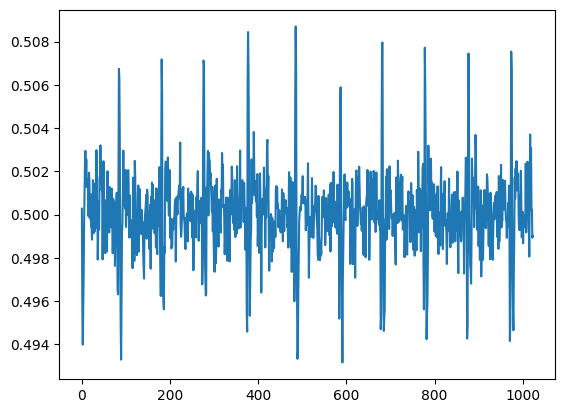

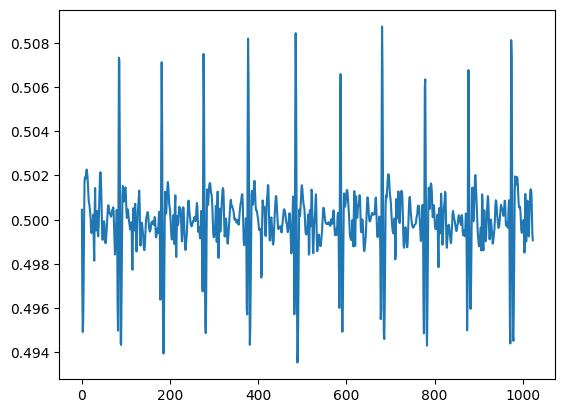

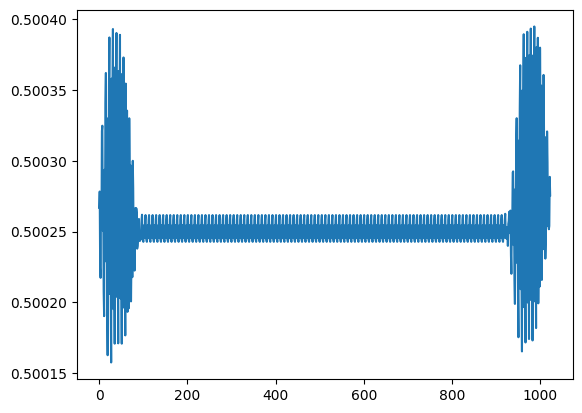

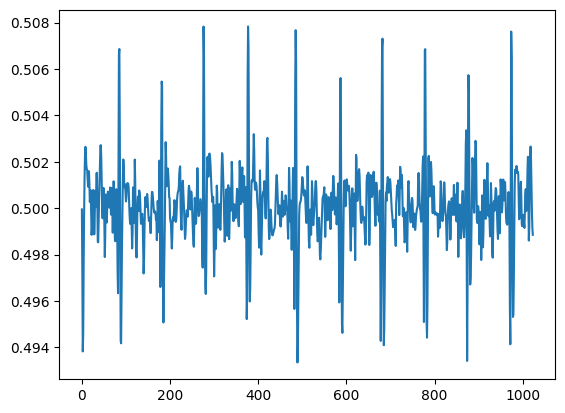

In [48]:
model = DeNoise2D().to(device)
# model.load_state_dict(torch.load('model.pth'))
model.load_state_dict(model_state)
model.eval()


#0.0001260456
with torch.no_grad():
    
    noise = dataset[100][0].reshape(-1, 1, segment_size_samples).to(device)
    clean = dataset[100][1].reshape(-1, 1, segment_size_samples).to(device)

    predicted = model(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')


    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time = 1024

    plt.plot(range(time)[time_from:time], noise[time_from:time])
    plt.show()
    plt.plot(range(time)[time_from:time], clean[time_from:time])
    plt.show()
    plt.plot(range(time)[time_from:time], predicted[time_from:time])
    plt.show()
    plt.plot(range(time)[time_from:time], predicted2[time_from:time])
    plt.show()
    
    torch.cuda.empty_cache()